In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'relative'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.048578994407056 	 Validation loss: 2.0032535084223344 	 
  1%|          | 574/57400 [01:44<2:42:40,  5.82it/s]
Epoch 2 	 Training loss: 1.9887661601608224 	 Validation loss: 1.9943990182068387 	 
  2%|▏         | 1148/57400 [03:41<2:37:05,  5.97it/s]
Epoch 3 	 Training loss: 1.9809838182419435 	 Validation loss: 1.98113659074751 	 
  3%|▎         | 1722/57400 [05:37<2:34:09,  6.02it/s]
Epoch 4 	 Training loss: 1.9757852249029206 	 Validation loss: 1.9751843557519428 	 
  4%|▍         | 2296/57400 [07:34<2:37:09,  5.84it/s]
Epoch 5 	 Training loss: 1.9717930623878586 	 Validation loss: 1.9720019465785916 	 
  5%|▌         | 2870/57400 [09:31<2:41:21,  5.63it/s]
Epoch 6 	 Training loss: 1.9668253512748026 	 Validation loss: 1.975437772476067 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [11:27<2:25:33,  6.18it/s]
Epoch 7 	 Training loss: 1.9653464620121681 	 Validation loss: 1.9740194850048776 	 

2 epoch without improvement
  7%|▋         | 4018/

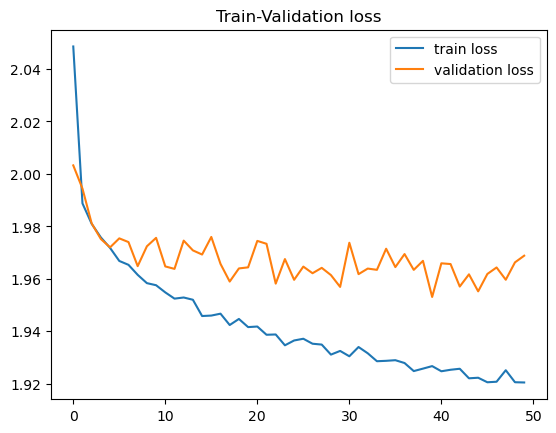

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_relative_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7184343434343434, 'precision': 0.7184343434343434, 'f1': 0.7184343434343435, 'accuracy': 0.7184343434343434}, 'as': {'recall': 0.7314211212516297, 'precision': 0.7314211212516297, 'f1': 0.7314211212516297, 'accuracy': 0.7314211212516297}, 'about': {'recall': 0.8443877551020408, 'precision': 0.8443877551020408, 'f1': 0.8443877551020407, 'accuracy': 0.8443877551020408}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7493917274939172, 'precision': 0.7493917274939172, 'f1': 0.7493917274939172, 'accuracy': 0.7493917274939172}, 'as': {'recall': 0.7525252525252525, 'precision': 0.7525252525252525, 'f1': 0.7525252525252525, 'accuracy': 0.7525252525252525}, 'about': {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402}, 'a

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0585245745522633 	 Validation loss: 2.0028914556664934 	 
  1%|          | 574/57400 [01:45<2:42:18,  5.83it/s]
Epoch 2 	 Training loss: 1.9976504181320243 	 Validation loss: 1.9862678919808339 	 
  2%|▏         | 1148/57400 [03:30<2:42:34,  5.77it/s]
Epoch 3 	 Training loss: 1.9866888442105948 	 Validation loss: 1.983093835539737 	 
  3%|▎         | 1722/57400 [05:16<2:20:02,  6.63it/s]
Epoch 4 	 Training loss: 1.980019681960448 	 Validation loss: 1.9770666967004031 	 
  4%|▍         | 2296/57400 [07:01<2:29:55,  6.13it/s]
Epoch 5 	 Training loss: 1.9735349603646308 	 Validation loss: 1.9788187903872991 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:47<2:16:03,  6.68it/s]
Epoch 6 	 Training loss: 1.9704038241183717 	 Validation loss: 1.9742788722959614 	 
  6%|▌         | 3444/57400 [10:32<2:39:36,  5.63it/s]
Epoch 7 	 Training loss: 1.9672246957489838 	 Validation loss: 1.9711172621128923 	 
  7%|▋         | 4018/57400 [12:17<2:19:45,  6.37

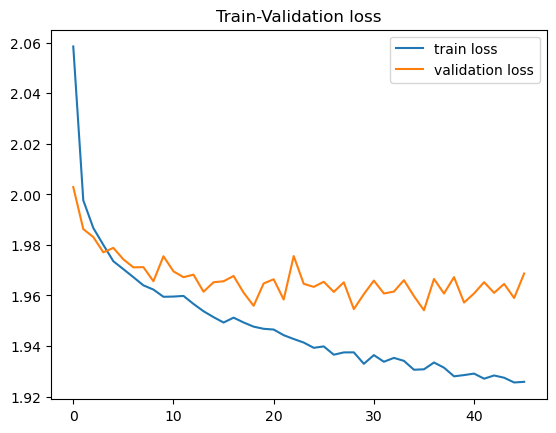

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_relative_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7184343434343434, 'precision': 0.7184343434343434, 'f1': 0.7184343434343435, 'accuracy': 0.7184343434343434}, 'as': {'recall': 0.7249022164276402, 'precision': 0.7249022164276402, 'f1': 0.7249022164276402, 'accuracy': 0.7249022164276402}, 'about': {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979592, 'accuracy': 0.8431122448979592}} 

Evaluación en etiquetas male
{'to': {'recall': 0.732360097323601, 'precision': 0.732360097323601, 'f1': 0.732360097323601, 'accuracy': 0.732360097323601}, 'as': {'recall': 0.7373737373737373, 'precision': 0.7373737373737373, 'f1': 0.7373737373737375, 'accuracy': 0.7373737373737373}, 'about': {'recall': 0.8515625, 'precision': 0.8515625, 'f1': 0.8515625, 'accuracy': 0.8515625}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7034120734908137, 'precision': 0.7034120734908137, 'f1': 0.7034120734908137, 'accuracy': 0.7034120734908137}, 'as': {'recall': 0.7115902964959568, 'prec

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0403252700895385 	 Validation loss: 2.003806855718968 	 
  1%|          | 574/57400 [01:47<2:19:45,  6.78it/s]
Epoch 2 	 Training loss: 1.9901951225377126 	 Validation loss: 1.9751164327233524 	 
  2%|▏         | 1148/57400 [03:34<2:40:39,  5.84it/s]
Epoch 3 	 Training loss: 1.9802017718657383 	 Validation loss: 1.972472071647644 	 
  3%|▎         | 1722/57400 [05:20<2:37:38,  5.89it/s]
Epoch 4 	 Training loss: 1.9760624920034242 	 Validation loss: 1.9705112364332555 	 
  4%|▍         | 2296/57400 [07:07<2:56:31,  5.20it/s]
Epoch 5 	 Training loss: 1.9726752595203678 	 Validation loss: 1.9710514909130032 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:53<2:42:20,  5.60it/s]
Epoch 6 	 Training loss: 1.9680346819581886 	 Validation loss: 1.9761002265800864 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:39<2:42:28,  5.53it/s]
Epoch 7 	 Training loss: 1.9643616591181075 	 Validation loss: 1.9675449233944133 	 
  7%|▋         | 401

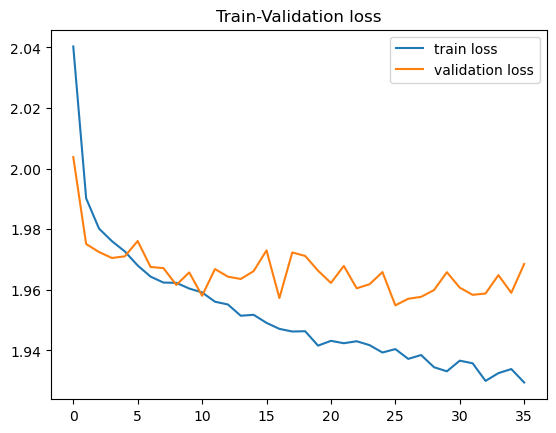

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_relative_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7184343434343434, 'precision': 0.7184343434343434, 'f1': 0.7184343434343435, 'accuracy': 0.7184343434343434}, 'as': {'recall': 0.7327249022164276, 'precision': 0.7327249022164276, 'f1': 0.7327249022164276, 'accuracy': 0.7327249022164276}, 'about': {'recall': 0.8545918367346939, 'precision': 0.8545918367346939, 'f1': 0.8545918367346939, 'accuracy': 0.8545918367346939}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}, 'as': {'recall': 0.73989898989899, 'precision': 0.73989898989899, 'f1': 0.73989898989899, 'accuracy': 0.73989898989899}, 'about': {'recall': 0.8645833333333334, 'precision': 0.8645833333333334, 'f1': 0.8645833333333333, 'accuracy': 0.8645833333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7007874015748031, 'precision': 0.7007874015748031, 'f1': 0.7007874015748031, 'accuracy': 0.7007874015748031}, 'as': {'re

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8473639455782312, 'precision': 0.8473639455782312, 'f1': 0.8473639455782312, 'accuracy': 0.8473639455782312}
Métricas etiqueta male: {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333333, 'accuracy': 0.8567708333333334}
Métricas etiqueta female:  {'recall': 0.8383333333333333, 'precision': 0.8383333333333333, 'f1': 0.8383333333333333, 'accuracy': 0.8383333333333333}

 to
Resultado global: {'recall': 0.7184343434343434, 'precision': 0.7184343434343434, 'f1': 0.7184343434343435, 'accuracy': 0.7184343434343434}
Métricas etiqueta male: {'recall': 0.7388483373884833, 'precision': 0.7388483373884833, 'f1': 0.7388483373884833, 'accuracy': 0.7388483373884833}
Métricas etiqueta female:  {'recall': 0.6964129483814523, 'precision': 0.6964129483814523, 'f1': 0.6964129483814523, 'accuracy': 0.6964129483814523}

 as
Resultado global: {'recall': 0.7296827466318991, 'precision': 0.7296827466318991, 'f1': 0.7